In [1]:
###############################
import math
import time
import random
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import pickle
from matplotlib.colors import ListedColormap
###############################

In [2]:
%run grid_no_ap.ipynb

main
2000


In [3]:
####################################
# Augmenting path algorithm
####################################

IND_YES = 1     # point is in circle/square
IND_NO = 0      # point is in neither circle nor square. It cannot be a node in the graph.
IND_MATCHED = 2 # point that has been matched
direction =       [(0,0),    (1,0),    (1,1),    (0,1),    (-1,1),   (-1,0),   (-1,-1),  (0,-1),   (1,-1)]
direction_arrow = ["\u2022", "\u2193", "\u2198", "\u2192", "\u2197", "\u2191", "\u2196", "\u2190", "\u2199"] 
#direction = [(0,0), (-1,0), (-1,-1), (0,-1), (1,-1), (1,0), (1,1), (0,1), (-1,1)]
#direction_arrow = ["\u2022", "\u2191", "\u2196", "\u2190", "\u2199", "\u2193", "\u2198", "\u2192", "\u2197"] 

# Function that returns whether there is an edge 
# Input: edge (tuple_start, tuple_end), grid; or should it be grid_sq, grid_circ
# All edges from SOURCE to grid have capacity 1. All edges from grid to SINK have cap 1. 
# Edges within grid have infinite capacity -- here represented by GRID_SIZE**2, as flow can't be greater than that
# Nonexistent edges have capacity 0.

def is_edge(edge, grid1, grid2):
    start = edge[0]
    end = edge[1]
    
    i,j,k,l = start[0], start[1], end[0], end[1]
    
    if k < 0 or k >= GRID_SIZE or l < 0 or l >= GRID_SIZE:
        return False
    
    if grid1[i][j] == IND_YES:
        if grid2[k][l] == IND_YES:
            if abs(i-k) <= 1 and abs(j-l) <= 1:
                return True

    return False


# Function that prints visual representation of matched_edges_sq, matched_edges_circ
def print_matched_edges(matched_edges):
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if matched_edges[i][j] == 0: # no point there
                print(" ", end=" ")
            else:
                for d in range(len(direction)):
                    if matched_edges[i][j] == direction[d]:
                        print(direction_arrow[d], end= " ")
        print()
        
    return None


# Function that checks if matched_edges_sq and _circ are equivalent
# Returns an incorrectly matched edge if there is one; otherwise return 0
def check_matched_edges(me_sq, me_circ):
    
    num_unmatched = 0
    unmatched = list()
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if me_sq[i][j] != 0:
                d = me_sq[i][j]
                fro = me_circ[i+d[0]][j+d[1]]
                if fro[0] != -d[0] or fro[1] != -d[1]:
                    num_unmatched += 1
                    unmatched.append(("sq",i,j))
                
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if me_circ[i][j] != 0:
                d = me_circ[i][j]
                fro = me_sq[i+d[0]][j+d[1]]
                if fro[0] != -d[0] or fro[1] != -d[1]:
                    num_unmatched += 1
                    unmatched.append(("circ",i,j))
    
    return num_unmatched, unmatched


# Function that plots histogram of the path lenghts encountered during aug_path BFS
# https://stackoverflow.com/questions/33203645/how-to-plot-a-histogram-using-matplotlib-in-python-with-a-list-of-data
def plot_hist(len_paths):
    x = np.array(len_paths)
    percentile_array = [70,80,90,95,97.5]
    print(percentile_array)
    print(np.percentile(x, percentile_array))
    print("Max of count_path_len is " + str(np.percentile(x,100)))
    
    # Freedman–Diaconis method to find best number of bins
    q25, q75 = np.percentile(x, [25, 75])
    bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
    nbins = round((x.max() - x.min()) / (bin_width+1))
    
    # plot histogram
    plt.hist(x, density=True, bins=nbins)
    plt.xlabel("Length of path")
    plt.ylabel("Frequency")


# Augmenting path algorithm
# Input: grid of *,+,-,0
def aug_path(grid, print_grid=False, debug=False):
    
    # Set up grids for circle and square
    grid_sq = list() 
    grid_circ = list()
    for i in range(GRID_SIZE):
        gr_sq_row = list()
        gr_circ_row = list()
        for j in range(GRID_SIZE):
            if grid[i][j] == '*':
                gr_sq_row.append(IND_YES)
                gr_circ_row.append(IND_YES)
            elif grid[i][j] == '+':
                gr_sq_row.append(IND_YES)
                gr_circ_row.append(IND_NO)
            elif grid[i][j] == '-':
                gr_sq_row.append(IND_NO)
                gr_circ_row.append(IND_YES)
            else:
                gr_sq_row.append(IND_NO)
                gr_circ_row.append(IND_NO)
            
        grid_sq.append(gr_sq_row)
        grid_circ.append(gr_circ_row)
        
    
    # Find all edges 
    edges_sq_to_circ = list() 
    edges_circ_to_sq = list()
    for i in range(GRID_SIZE):
        edges_sc_row = list()
        edges_cs_row = list()
        for j in range(GRID_SIZE):
            edges_sc_ij = list()
            edges_cs_ij = list()
            for d in direction:
                if is_edge(((i,j),(i+d[0],j+d[1])), grid_sq, grid_circ):
                    edges_sc_ij.append(d)
                if is_edge(((i,j),(i+d[0],j+d[1])), grid_circ, grid_sq):
                    edges_cs_ij.append(d)
            edges_sc_row.append(edges_sc_ij)
            edges_cs_row.append(edges_cs_ij)
        edges_sq_to_circ.append(edges_sc_row)
        edges_circ_to_sq.append(edges_cs_row)
                
            
    # Print if needed   
    if print_grid:
        print("Square:")
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                print(grid_sq[i][j], end=" ")
            print()
        
        print("Circle:")
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                print(grid_circ[i][j], end=" ")
            print()
                
                
    # Set up 2d arrays to remember which edge we picked for matching
    # Both arrays will essentially contain the same info, but we create two copies for convenience
    matched_edges_sq = list() 
    matched_edges_circ = list()
    for i in range(GRID_SIZE):
        list_of_zeros = [0]*GRID_SIZE
        also_list_of_zeros = [0]*GRID_SIZE # so python doesn't make the same 2d array twice
        matched_edges_sq.append(list_of_zeros)
        matched_edges_circ.append(also_list_of_zeros)
            
    
    # BFS for finding augmenting path
    BORDER = 1 # thickness of border
    MAX_EXPLORE = 10000 # max num of points to explore before giving up
    len_paths = list()
    
    for i in range(BORDER,GRID_SIZE-BORDER):
        if i%10 == 0:
            print("Looking at row: " + str(i))
        for j in range(BORDER,GRID_SIZE-BORDER):
            if grid_sq[i][j] == IND_YES:
                #print("Looking at point: "+str(i)+","+str(j))
                Q = deque()
                explored = list()
                explored.append(("sq",i,j))
                Q.append(("sq",i,j))
                while len(Q) > 0:
                    if len(explored) > MAX_EXPLORE:
                        print("More than "+str(MAX_EXPLORE)+" points explored--skipping point ("+str(i)+","+str(j)+")")
                        len_paths.append(MAX_EXPLORE)
                        break
                    v = Q.popleft()
                    if debug: 
                        print("v = " + str(v))
                        print("matched_edges_sq: ")
                        print_matched_edges(matched_edges_sq) 
                        print("matched_edges_circ: ")
                        print_matched_edges(matched_edges_circ)
                    k,l = v[1], v[2]
                    if v[0] == "sq":
                        if grid_sq[k][l] == IND_YES and len(v) != 3: #and ("sq",k,l) not in explored:
                            # this is the goal. return. track v's
                            if debug: print("Reached goal in sq, now backtracking")
                            count_path_len = 0
                            while len(v) > 3:
                                k,l = v[1], v[2] # current
                                prev = v[3] 
                                a,b = prev[1], prev[2] # previous
                                count_path_len += 1
                                if v[0] == "sq":
                                    # if edge was originally matched, unmatch them by simply NOT updating the edge
                                    if matched_edges_sq[k][l] != 0 and matched_edges_circ[a][b] != 0:
                                        if debug: 
                                            print("type 1")
                                        pass
                                    # if edge was originally unmatched, do match them
                                    else:
                                        matched_edges_sq[k][l] = (a-k, b-l) #
                                        matched_edges_circ[a][b] = (k-a, l-b) #
                                    grid_sq[k][l] = IND_MATCHED

                                elif v[0] == "circ":
                                    if matched_edges_sq[a][b] != 0 and matched_edges_circ[k][l] != 0:
                                        if debug: 
                                            print("type 2")
                                        pass
                                    else:
                                        matched_edges_sq[k][l] = (k-a, l-b) ##
                                        matched_edges_circ[a][b] = (a-k, b-l) ##
                                    grid_circ[k][l] = IND_MATCHED
                                v = v[3]
                                if debug:
                                    print("(backtrack) matched_edges_sq: ")
                                    print_matched_edges(matched_edges_sq) 
                                    print("(backtrack) matched_edges_circ: ")
                                    print_matched_edges(matched_edges_circ)
                            grid_sq[i][j] = IND_MATCHED
                            len_paths.append(count_path_len)
                            break

                        for d in edges_sq_to_circ[k][l]:
                            if (d[0],d[1]) != matched_edges_sq[k][l]:    # if unmatched
                                if ("circ", k+d[0], l+d[1]) not in explored:  # and unexplored
                                    explored.append(("circ", k+d[0], l+d[1]))
                                    Q.append(("circ", k+d[0], l+d[1], v))
                                    if debug: print("appended: (circ,"+str(k+d[0])+","+str(l+d[1])+","+str(v)+")")

                    elif v[0] == "circ":
                        if grid_circ[k][l] == IND_YES: #and ("circ",k,l) not in explored:
                            # this is the goal. return. track v's
                            if debug: print("Reached goal in circ, now backtracking")
                            count_path_len = 0
                            while len(v) > 3:
                                k,l = v[1], v[2]
                                prev = v[3] 
                                a,b = prev[1], prev[2]
                                count_path_len += 1
                                if debug: print("a,b; k,l: " + str(a)+","+str(b)+"; "+str(k)+","+str(l))
                                if v[0] == "sq":
                                    if matched_edges_sq[k][l] != 0 and matched_edges_circ[a][b] != 0:
                                        if debug: 
                                            print("type 3")
                                            #print("unmatch edge from ("+str(k)+","+str(l)+") to ("+str(a)+","+str(b)+")")
                                        pass
                                    else:
                                        matched_edges_sq[k][l] = (a-k, b-l) #
                                        matched_edges_circ[a][b] = (k-a, l-b) #
                                    grid_sq[k][l] = IND_MATCHED

                                elif v[0] == "circ":
                                    """ # apparently removing this portion fixed the bug. But how?
                                    if matched_edges_sq[a][b] != 0 and matched_edges_circ[k][l] != 0:
                                        if debug: 
                                            print("type 4")
                                            #print("unmatch edge from ("+str(a)+","+str(b)+") to ("+str(k)+","+str(l)+")")
                                        pass
                                    else:
                                    """
                                    matched_edges_sq[a][b] = (k-a, l-b) ##
                                    matched_edges_circ[k][l] = (a-k, b-l) ##
                                    grid_circ[k][l] = IND_MATCHED
                                v = v[3] 
                                if debug:
                                    print("(backtrack) matched_edges_sq: ")
                                    print_matched_edges(matched_edges_sq) 
                                    print("(backtrack) matched_edges_circ: ")
                                    print_matched_edges(matched_edges_circ)
                            grid_sq[i][j] = IND_MATCHED
                            len_paths.append(count_path_len)
                            break

                        if debug: print(Q)
                        d = matched_edges_circ[k][l]
                        if ("sq", k+d[0], l+d[1]) not in explored:  #if matched and explored
                            explored.append(("sq", k+d[0], l+d[1]))
                            Q.append(("sq", k+d[0], l+d[1], v))
                            if debug: print("appended: (sq,"+str(k+d[0])+","+str(l+d[1])+","+str(v)+")")

                if grid_sq[i][j] != IND_MATCHED and len(explored) <= MAX_EXPLORE:
                    raise Exception("No path was found out of (" + str(i) + "," + str(j) + ")")
                    #Note that we are not checking to see that all points of circle are matched
        
    
    if print_grid:
        print("matched_edges_sq: ")
        print_matched_edges(matched_edges_sq) 
        print("matched_edges_circ: ")
        print_matched_edges(matched_edges_circ)
        
    print("Check if matched edges are consistent (0=is consistent): ")
    unmatched_count, unmatched_pts = check_matched_edges(matched_edges_sq, matched_edges_circ)
    print(unmatched_count)
    print(unmatched_pts)
    
    print("Histogram of path lengths encountered in aug_path BFS: ")
    plot_hist(len_paths)
    
    return matched_edges_sq, matched_edges_circ


In [95]:
####################################
# Use matplotlib
####################################


# Create pic of circle and square
# Cycle through 2000*2000 grid. O(N^2)
# coords = output of make_set; me_sq = matched_edges_sq/circ; square = True for me_sq, False for me_circ
def make_figure(coords, me_sq, is_square):
    GR = 500
    
    closest_pts = list()
    for i in range(GR):
        closest_pts_row = list()
        for j in range(GR):
            closest_pts_row.append(list())
        closest_pts.append(closest_pts_row)
            
    print("Constructing closest_pts")
    for i in range(GRID_SIZE):
        if i%10 == 0: 
            print("row: " + str(i))
        for j in range(GRID_SIZE):
            if me_sq[i][j] != 0:  # This was for a speedup in runtime. Will cause diagram to 
                                  #  prioritize pts in square over pts not in square
                                  #  When I removed this everything stopped working. So we're keeping this
                x,y = coords[i][j]
                # find closest pixel for (x,y) and add to list
                x_, y_ = int(x*GR), int(y*GR)
                closest_pts[x_][y_].append((i,j))
    
    # 2D array, at each pixel [i][j] is the direction of flow out of square, of the point closest to [i][j]
    #  formed from the vectors u1, u2
    print("Constructing closest_dir")
    closest_dir = list()
    for i in range(GR):
        closest_dir_row = list()
        for j in range(GR):
            list_of_closest = closest_pts[i][j] 
            print("("+str(i)+","+str(j)+"): length of list_of_closest = " + str(len(list_of_closest)))
            if len(list_of_closest) == 0: # No points corr. to this pixel
                min_dist = 1
                i_ = -1
                j_ = -1
                for k in range(-1,2):
                    for l in range(-1,2):
                        #print("in in: "+str(k)+", "+str(l))
                        if 0 <= i+k < GR and 0 <= j+l < GR:
                            #print("in in in: "+str(k)+", "+str(l))
                            #print("len(closest_pts["+str(i+k)+"]["+str(j+l)+"]): " +str(len(closest_pts[i+k][j+l])))
                            for m in range(len(closest_pts[i+k][j+l])):
                                #print("in in in in")
                                x,y = closest_pts[i+k][j+l][m]
                                if math.dist(coords[x][y], (i/GR,j/GR)) < min_dist:
                                    min_dist = math.dist(coords[x][y], (i/GR,j/GR))
                                    i_, j_ = x, y
                
                if i_ == -1 or j_ == -1:
                    closest_dir_row.append(0)
                    print("appended 0, no points nearby")
                else:
                    for k in range(len(direction)):
                        if me_sq[i_][j_] == direction[k]:
                            closest_dir_row.append(k+1)
                            print("appended "+str(k+1))
                
            elif len(list_of_closest) == 1: # Exactly one point corr. to this pixel
                i_,j_ = list_of_closest[0]
                for k in range(len(direction)):
                    if me_sq[i_][j_] == direction[k]:
                        closest_dir_row.append(k+1)
                    
            else: # Many points corr. to this pixel. Find closest pt to this pixel and use that one.
                min_dist = 1
                i_ = -1
                j_ = -1
                for k in range(len(list_of_closest)):
                    x,y = list_of_closest[k]
                    if math.dist(coords[x][y], (i/GR,j/GR)) < min_dist:
                        min_dist = math.dist(coords[x][y], (i/GR,j/GR))
                        i_, j_ = x, y
                for k in range(len(direction)):
                    if me_sq[i_][j_] == direction[k]:
                        closest_dir_row.append(k+1)
        closest_dir.append(closest_dir_row)
                
    if is_square:
        with open('dir_pixels_sq.pickle', 'wb') as to_write:
            pickle.dump(closest_dir, to_write)
    else:
        with open('dir_pixels_circ.pickle', 'wb') as to_write:
            pickle.dump(closest_dir, to_write)
        
        
# Create pic of circle and square
def plt_figure(is_square):
    
    if is_square:
        with open('dir_pixels_sq.pickle', 'rb') as read_file:
            closest_dir = pickle.load(read_file)
    else:
        with open('dir_pixels_circ.pickle', 'rb') as read_file:
            closest_dir = pickle.load(read_file)
    
    invert_colors = [0,1,6,7,8,9,2,3,4,5]
    color_map=ListedColormap(["white","grey","red","blue","green","black","magenta", "aqua", "yellow","goldenrod"])
    
    # plot grid
    GR = 500
    x = np.linspace(0, 1, GR)[:-1] # don't include x=1
    y = np.linspace(0, 1, GR)[:-1]
    X, Y = np.meshgrid(x, y)
    
    count = [0]*10
    Z = np.empty([len(y),len(x)])
    for i in range(len(x)):
        for j in range(len(y)):
            count[closest_dir[j][i]] += 1
            if is_square:
                Z[j][i] = closest_dir[j][i]
            else:
                Z[j][i] = invert_colors[closest_dir[j][i]]
                
    
    for i in range(len(count)):
        print("count["+str(i)+"] = "+str(count[i]))
    
    plt.pcolor(Z, cmap=color_map)
    plt.colorbar()
    plt.show()
    
    
    
# Testing aug_path function + storing it in pickle files
def test_aug_path():
    v = (0,0) 
    pt = (0,0) 
    """
    list_u = [(0.1369585656765282, 0.016999404787337746), (0.4391535837866679, 0.8587283739534641),
              (0.8421385012171291, 0.8272277649876393), (0.8554876974387439, 0.4254061697343674),
              (0.05464147301595168, 0.8340091362353484), (0.7091983960546916, 0.855960876965961),
              (0.009601617940946827, 0.2876408268945586), (0.14390753070834938, 0.5662824564679872),
              (0.5697351920636861, 0.28956470378753507), (0.7293022302825091, 0.061654116242531254),
              (0.12899564371330774, 0.022282518214378766), (0.07011812618338864, 0.7130289886950659),
              (0.11780364045386771, 0.9687294700524799), (0.5714476731089351, 0.7153734688938803),
              (0.7235998956991657, 0.43969206748375345), (0.4683340831981275, 0.3678042600988708)]
    """
    
    u1 = (1/math.sqrt(2),1/math.sqrt(2))
    u2 = (1/math.sqrt(3),1/math.sqrt(5))
    print("u1 = " + str(u1))
    print("u2 = " + str(u2))

    grid = make_grid(v, pt, GRID_SIZE, u1, u2, print_grid=False)
    tic = time.perf_counter()

    me_sq, me_circ = aug_path(grid,print_grid=False, debug=False)
    toc = time.perf_counter()
    print("time elapsed: " + str(toc-tic) + " sec")
    
    with open('me_sq.pickle', 'wb') as to_write:
        pickle.dump(me_sq, to_write)
        
    with open('me_circ.pickle', 'wb') as to_write:
        pickle.dump(me_circ, to_write)
    
    

In [131]:
####################################
# Use matplotlib, but with 36+1 colors
####################################

# Returns number 1-33 corr. to which vector and which direction they overflow
# Output 1 = direction[0] (0,0)
# Output 2-5 = direction[1] with mod 1-4
# Output 6-9 = direction[2] with mod 1-4, and so on.

def which_mod(xy_coord, k, u1, u2):
    x,y = xy_coord
    d1, d2 = direction[k]
    new_x = d1*u1[0]+d2*u2[0]+x 
    new_y = d1*u1[1]+d2*u2[1]+y 
    G=4
    if k == G:
        print("xy_coord: "+str(xy_coord)+", new_x: "+str(new_x)+", new_y: "+str(new_y))
    
    if k == 0: # point maps to itself, vector transposed by is (0,0)
        return 1
    elif new_x == new_x%1 and new_y == new_y%1: # did not overflow
        if k==G: print("return "+str(4*k-2))
        return 4*k-2
    elif new_x != new_x%1 and new_y == new_y%1: # overflow in x only
        if k==G: print("return "+str(4*k-1))
        return 4*k-1
    elif new_x == new_x%1 and new_y != new_y%1: # overflow in y only
        if k==G: print("return "+str(4*k))
        return 4*k
    elif new_x != new_x%1 and new_y != new_y%1: # overflow in both x and y
        if k==G: print("return "+str(4*k+1))
        return 4*k+1
    else: 
        raise Exception("Error in which_mod function")
    

    
# Create pic of circle and square
# Cycle through 2000*2000 grid. O(N^2)
# coords = output of make_set; me_sq = matched_edges_sq/circ; square = True for me_sq, False for me_circ

def make_figure4(coords, me_sq, is_square, u1, u2):
    GR = 500
    
    closest_pts = list()
    for i in range(GR):
        closest_pts_row = list()
        for j in range(GR):
            closest_pts_row.append(list())
        closest_pts.append(closest_pts_row)
            
    print("Constructing closest_pts")
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if me_sq[i][j] != 0:  # This was for a speedup in runtime. Will cause diagram to 
                                  #  prioritize pts in square over pts not in square
                x,y = coords[i][j]
                # find closest pixel for (x,y) and add to list
                x_, y_ = int(x*GR), int(y*GR)
                closest_pts[x_][y_].append((i,j))
    
    # 2D array, at each pixel [i][j] is the direction of flow out of square, of the point closest to [i][j]
    #  formed from the vectors u1, u2
    print("Constructing closest_dir")
    closest_dir = list()
    for i in range(GR):
        closest_dir_row = list()
        for j in range(GR):
            list_of_closest = closest_pts[i][j] 
            print("("+str(i)+","+str(j)+"): length of list_of_closest = " + str(len(list_of_closest)))
            if len(list_of_closest) == 0: # No points corr. to this pixel. Check nearby points
                min_dist = 1
                i_ = -1
                j_ = -1
                for k in range(-1,2):
                    for l in range(-1,2):
                        if 0 <= i+k < GR and 0 <= j+l < GR:
                            for m in range(len(closest_pts[i+k][j+l])):
                                x,y = closest_pts[i+k][j+l][m]
                                if math.dist(coords[x][y], (i/GR,j/GR)) < min_dist:
                                    min_dist = math.dist(coords[x][y], (i/GR,j/GR))
                                    i_, j_ = x, y
                
                if i_ == -1 or j_ == -1:
                    closest_dir_row.append(0)
                    #print("appended 0, no points nearby")
                else:
                    for k in range(len(direction)):
                        if me_sq[i_][j_] == direction[k]:
                            # check for mod 1-4
                            mod = which_mod(coords[i_][j_], k, u1, u2)
                            closest_dir_row.append(mod)
                            #print("appended "+str(mod))
                
            elif len(list_of_closest) == 1: # Exactly one point corr. to this pixel
                i_,j_ = list_of_closest[0]
                for k in range(len(direction)):
                    if me_sq[i_][j_] == direction[k]:
                        mod = which_mod(coords[i_][j_], k, u1, u2)
                        closest_dir_row.append(mod)
                    
            else: # Many points corr. to this pixel. Find closest pt to this pixel and use that one.
                min_dist = 1
                i_ = -1
                j_ = -1
                for k in range(len(list_of_closest)):
                    x,y = list_of_closest[k]
                    if math.dist(coords[x][y], (i/GR,j/GR)) < min_dist:
                        min_dist = math.dist(coords[x][y], (i/GR,j/GR))
                        i_, j_ = x, y
                for k in range(len(direction)):
                    if me_sq[i_][j_] == direction[k]:
                        mod = which_mod(coords[i_][j_], k, u1, u2)
                        closest_dir_row.append(mod)
        closest_dir.append(closest_dir_row)
                
    if is_square:
        with open('dir_pixels_sq_mod.pickle', 'wb') as to_write:
            pickle.dump(closest_dir, to_write)
    else:
        with open('dir_pixels_circ_mod.pickle', 'wb') as to_write:
            pickle.dump(closest_dir, to_write)
        
        
# Create pic of circle and square
def plt_figure4(is_square):
    
    if is_square:
        with open('dir_pixels_sq_mod.pickle', 'rb') as read_file:
            closest_dir = pickle.load(read_file)
    else:
        with open('dir_pixels_circ_mod.pickle', 'rb') as read_file:
            closest_dir = pickle.load(read_file)
    
    if is_square:
        """
        color_map=ListedColormap(["white","grey",
                                  "red", "red", "red", "red",
                                  "blue", "blue", "blue", "blue", 
                                  "green", "green", "green", "green",
                                  "black", "black", "black", "black",  # TODO: why did this work??
                                  "magenta", "magenta", "magenta","magenta", 
                                  "aqua", "aqua", "aqua", "aqua", 
                                  "yellow", "yellow", "yellow", "yellow",
                                  "goldenrod", "goldenrod", "goldenrod"])
        """
        color_map=ListedColormap(["white","grey",
                                  "lightcoral", "indianred", "brown", "maroon",
                                  "lightblue", "deepskyblue", "dodgerblue", "steelblue", 
                                  "palegreen", "limegreen", "green", "darkgreen",
                                  "blue", "mediumblue", "darkblue", "navy",
                                  "pink", "orchid", "magenta","darkmagenta", 
                                  "paleturquoise", "aqua", "darkturquoise", "teal", 
                                  "lightyellow", "yellow", "orange", "darkorange",
                                  "palegoldenrod", "gold", "goldenrod"])
        #"""
    else:
        """
        color_map=ListedColormap(["white","grey",
                                  "magenta", "magenta", "magenta","magenta", 
                                  "aqua", "aqua", "aqua", "aqua", 
                                  "yellow", "yellow", "yellow", "yellow",
                                  "goldenrod", "goldenrod", "goldenrod", "goldenrod",  # TODO: ._.
                                  "red", "red", "red", "red",
                                  "blue", "blue", "blue", "blue", 
                                  "green", "green", "green", "green",
                                  "black", "black", "black"
                                  ])
        """
        color_map=ListedColormap(["white","grey",
                                  "pink", "orchid", "magenta","darkmagenta",  
                                  "paleturquoise", "aqua", "darkturquoise", "teal", 
                                  "lightyellow", "yellow", "orange", "darkorange",
                                  "palegoldenrod", "gold", "goldenrod", "darkgoldenrod", 
                                  "lightcoral", "indianred", "brown", "maroon",
                                  "lightblue", "deepskyblue", "dodgerblue", "steelblue", 
                                  "palegreen", "limegreen", "green", "darkgreen",
                                  "blue", "mediumblue", "darkblue"
                                  ])
        #"""
        
    # Seems like closest_dir[j][i]==17 having frequency of 0 is causing the shift in index of colors
    
    # plot grid
    GR = 500
    x = np.linspace(0, 1, GR)[:-1] # don't include x=1
    y = np.linspace(0, 1, GR)[:-1]
    X, Y = np.meshgrid(x, y)
    count = [0] * 34
    
    Z = np.empty([len(y),len(x)])
    for i in range(len(x)):
        for j in range(len(y)):
            Z[j][i] = closest_dir[j][i]
            count[closest_dir[j][i]] += 1
            
                
    
    print("count[0] = " +str(count[0]))
    print("count[1] = " +str(count[1]))
    print("count[2,3,4,5] = " +str(count[2])+","+str(count[3])+","+str(count[4])+","+str(count[5]))
    print("count[6,7,8,9] = " +str(count[6])+","+str(count[7])+","+str(count[8])+","+str(count[9]))
    print("count[10,11,12,13] = " +str(count[10])+","+str(count[11])+","+str(count[12])+","+str(count[13]))
    print("count[14,15,16,17] = " +str(count[14])+","+str(count[15])+","+str(count[16])+","+str(count[17]))
    print("count[18,19,20,21] = " +str(count[18])+","+str(count[19])+","+str(count[20])+","+str(count[21]))
    print("count[22,23,24,25] = " +str(count[22])+","+str(count[23])+","+str(count[24])+","+str(count[25]))
    print("count[26,27,28,29] = " +str(count[26])+","+str(count[27])+","+str(count[28])+","+str(count[29]))
    print("count[30,31,32,33] = " +str(count[30])+","+str(count[31])+","+str(count[32])+","+str(count[33]))
    #print(color_map.colors[18])
    
    plt.pcolor(Z, cmap=color_map)
    plt.colorbar()
    plt.show()
    

    
def test_plotting_colors():
    x = np.linspace(0, 1, 34)[:-1] # don't include x=1
    y = np.linspace(0, 1, 34)[:-1]
    X, Y = np.meshgrid(x, y)
    
    Z = np.empty([len(y),len(x)])
    for i in range(len(x)):
        for j in range(len(y)):
            Z[j][i] = j
            
    color_map=ListedColormap(["white","grey",
                              "lightcoral", "indianred", "brown", "maroon",
                              "lightblue", "deepskyblue", "dodgerblue", "steelblue", 
                              "palegreen", "limegreen", "green", "darkgreen",
                              "blue", "mediumblue", "darkblue", "navy",  # TODO: ??
                              "pink", "orchid", "magenta","darkmagenta", 
                              "paleturquoise", "aqua", "darkturquoise", "teal", 
                              "lightyellow", "yellow", "orange", "darkorange",
                              "palegoldenrod", "gold", "goldenrod", "darkgoldenrod"])
    
    plt.pcolor(Z, cmap=color_map)
    plt.colorbar()
    plt.show()
    
    

2000
time elapsed to read files: 0.8026925829981337 sec
time elapsed to make figure: 1.9193082499987213 sec
count[0] = 57258
count[1] = 29199
count[2] = 76961
count[3] = 59709
count[4] = 3325
count[5] = 3812
count[6] = 1094
count[7] = 2843
count[8] = 1855
count[9] = 12945


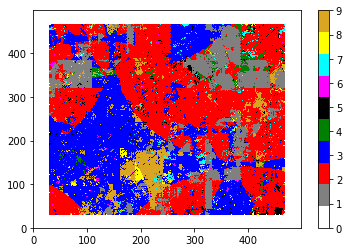

count[0] = 58251
count[1] = 29003
count[2] = 1126
count[3] = 2971
count[4] = 1920
count[5] = 12950
count[6] = 76613
count[7] = 59067
count[8] = 3288
count[9] = 3812


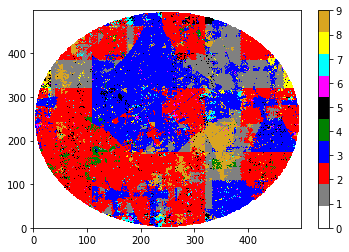

count[0] = 57258
count[1] = 29199
count[2,3,4,5] = 2635,12057,12040,50229
count[6,7,8,9] = 0,0,0,59709
count[10,11,12,13] = 317,647,284,2077
count[14,15,16,17] = 2715,597,500,0
count[18,19,20,21] = 10,115,228,741
count[22,23,24,25] = 0,0,0,2843
count[26,27,28,29] = 148,569,164,974
count[30,31,32,33] = 10496,382,2067,0


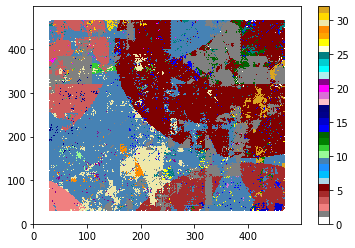

count[0] = 58251
count[1] = 29003
count[2,3,4,5] = 22,121,232,751
count[6,7,8,9] = 0,0,0,2971
count[10,11,12,13] = 128,607,172,1013
count[14,15,16,17] = 10441,389,2120,0
count[18,19,20,21] = 2467,11978,11992,50176
count[22,23,24,25] = 0,0,0,59067
count[26,27,28,29] = 283,639,294,2072
count[30,31,32,33] = 2784,537,491,0


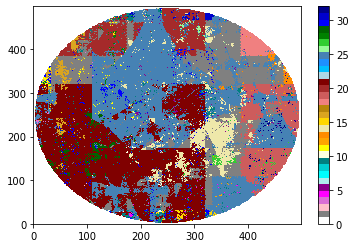

In [132]:
####################################
# main
####################################

def main():
    #test()
    
    v = (0,0) 
    pt = (0,0) 
    u1 = (1/math.sqrt(2),1/math.sqrt(2))
    u2 = (1/math.sqrt(3),1/math.sqrt(5))
    print(GRID_SIZE)
    #test_aug_path() #create and load data into pickle files
    
    tic = time.perf_counter()
    with open('me_sq.pickle', 'rb') as read_file:
        me_sq = pickle.load(read_file)
        
    with open('me_circ.pickle', 'rb') as read_file:
        me_circ = pickle.load(read_file)
    toc = time.perf_counter()
    print("time elapsed to read files: " + str(toc-tic) + " sec")
    
    tic = time.perf_counter()
    points = make_set(pt, GRID_SIZE, u1, u2)
    #make_figure(points, me_sq, True)
    #make_figure(points, me_circ, False)
    #make_figure4(points, me_sq, True, u1, u2)
    #make_figure4(points, me_circ, False, u1, u2)
    toc = time.perf_counter()
    print("time elapsed to make figure: " + str(toc-tic) + " sec")
    plt_figure(is_square=True)
    plt_figure(is_square=False)
    plt_figure4(is_square=True)
    plt_figure4(is_square=False)
    
    #test_plotting_colors()
    
    
if __name__ == "__main__":
    main()